# Assignment Netwerkanalyse

In [2]:
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
import numpy as np
from SPARQLWrapper import SPARQLWrapper, JSON
from pandas.io.json import json_normalize
import pandas as pd
import requests
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Een objectief beeld van het politieke klimaat 🗞️
#### een linked data project door Rama Pamudji

## Probleemstelling
Er is weinig kennis over de relatie tussen persoonlijke informatie van politici (zoals demografische gegevens) en de doelen die hun politieke partijen nastreven. De hypothese van dit Linked data project is dat een groot verband zou kunnen zijn tussen de persoonlijke kenmerken van politici en de kenmerken van hun partijen. Deze hypothese is gebaseerd op wetenschappelijk onderzoek, waaruit blijkt dat de context waarin het individu leeft invloed heeft op de ontwikkeling van gedrag en wereldbeeld. *“Confirmation bias is the tendency to search for, interpret, favor, and recall information in a way that confirms or supports one's prior beliefs or values”*. 

#### Geloven 💭, principes 🙌 en perceptie 👁️ 
De geloven, principes en perceptie die politici hebben vormen de basis voor hun beslissingen. Deze beslissingen leiden tot bepaalde uitkomsten en keuzes in hun leven. Een deel van deze uitkomsten en keuzes is publieke informatie opgeslagen in wikidata. Uitkomsten zoals de hoeveelheid kinderen die je heb en bij wat voor organisaties je hebt gewerkt. Maar ook keuzes over hoe je hebt gestemt over politieke onderwerpen. Dus we kunnen vanaf de uitkomsten en keuzes terugredeneren (tot op bepaald niveau!) naar wat ongeveer hun geloven, principes en perceptie zijn zijn.

#### Maar wat onderzoek je dan? 🔍
Het is dus interessant om te onderzoeken of dit ook geldt voor politici: Hebben politici van D66 gemiddeld gezien bijvoorbeeld meer kinderen dan politieke leiders van andere partijen? En zou je daaruit kunnen afleiden dat Sigrid Kaag (lijsttrekker D66) zich daarom meer inzet voor onderwijs? En heeft dit bijvoorbeeld te maken met het feit dat zij twee kinderen heeft die naar school gaan, en daardoor zelf meer in aanraking komt met onderwijs (en het belang ervan) dan Geert Wilder (lijsttrekker PVV) die geen kinderen heeft en wiens partij onderwijs een lager op het partijprogramma heeft staan? 

Dus, verwacht je dat een politici keuze A zou doen, maar in hun verkiezingsprogramma pleiten zij voor keuze B, hoe is dat dan te verklaren? Verwacht je van een politici keuze A en zei pleiten ook voor A, wat zegt dat dan over hen? Neemt de hoeveelheid vertrouwen in een politici toe wanneer deze te voorspellen is of juist af? Wat voor informatie heb je nog meer nodig om dat te zeggen? Dat laten we over aan het Nederlandse volk. Het in ieder geval interessante informatie die de beslissing om op iemand te stemmen flink kan beïnvloeden. **Ons doel is om deze data helder en inzichtelijk te maken, om zo objectieve informatie over het politieke klimaat te geven.** Zo herinneren wij Nederlanders er weer aan dat ook politici, net als zijzelf, voorspelbare mensen zijn.

## Aard van de data 📊

### SPARQL - Wikidata 🌐
Voordat politieke data-analyses uitgevoerd kunnen worden, zal er eerst data verzameld moeten worden. Als startpunt is er gekozen voor de bestaande dataset van wikidata: https://www.wikidata.org/wiki/Wikidata:WikiProject_every_politician/Netherlands/data/House/All_Members. Deze pagina met wikidata over alle politici inclusief hun start- en einddatum in de politiek is erg *sparse*. De pagina’s van de politici waarnaar gerefereerd wordt in deze lijst bevat echter veel interessante informatie. Van deze volksvertegenwoordigers is de onderstaande data verzameld. Op basis van deze deze data kan de ‘context’ van een politicus geschetst worden.

- Geslacht
- Land van burgerschap
- Geboortedatum
- Geboorteplek (stad)
- Moedertaal
- Gesproken/geschreven talen
- Beroep (incl. verleden beroepen)
- Werkgever (incl. verleden werkgevers)
- Positie in de politiek (incl. verleden posities)
- Opleiding (specifiek welke school)
- Woonplek
- Lid politieke partij (incl. verleden partijen)
- Religie
- Social media aanhang
- Instrument (muziek)
- Aantal kinderen
- Begin periode tweede kamer
- Eind periode tweede kamer


### Politici 👩‍💼👨‍💼
Omdat politici als [Abraham Boxman (1796-1856)](https://nl.wikipedia.org/wiki/Abraham_Boxman) voor het toekomstige politieke klimaat een  stuk minder relevant zijn dan volksvertegenwoordigers als [Sigrid Kaag](https://nl.wikipedia.org/wiki/Sigrid_Kaag), wordt er alleen data te verzameld van politici die mee doen aan de **Tweede Kamer verkiezingen van 2021**. Na het uitvoeren van een  SPARQL query blijkt dat 508 mensen zich verkiesbaar hebben gesteld voor de verkiezingen op 17 maart 2021. 

In [3]:
## sparql query for al politicians
sparql = SPARQLWrapper('https://query.wikidata.org/sparql')

sparql.setQuery('''
SELECT DISTINCT ?personLabel ?genderLabel ?partyLabel
WHERE {
    ?person wdt:P3602 wd:Q42733725.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
''')

sparql.setReturnFormat(JSON)
results = sparql.query().convert()
results_df = json_normalize(results['results']['bindings'])

verkiesbaar = list()

for x in range(len(results_df['personLabel.value'])):
    verkiesbaar.append(results_df['personLabel.value'][x])

print("Er doen", len(verkiesbaar), "volksvertegenwoordigers mee met de Tweede Kamerverkiezingen")
print("Hier een aantal voorbeelden", verkiesbaar[0:5])

Er doen 602 volksvertegenwoordigers mee met de Tweede Kamerverkiezingen
Hier een aantal voorbeelden ['Norbert Klein', 'Pieter Heerma', 'Geert Wilders', 'Roelof Bisschop', 'Ank Bijleveld']


### Partijen 🗣️
Naast historische politici zijn historische partijen ook minder interessant. Na het uitvoeren van weer een SPARQL query blijkt dat er  in totaal 43 partijen meedoen aan de Tweede Kamerverkiezingen van 2021. In de realiteit is dit anders, en zijn de namen van politieke partijen natuurlijk ook niet in het Engels. Daarom 'hardcoden' we politieke partijen in dit geval. In de reflectie komen we hier op terug.

In [4]:
## sparql query for al political parties
sparql = SPARQLWrapper('https://query.wikidata.org/sparql')

sparql.setQuery('''
SELECT DISTINCT ?personLabel ?genderLabel ?partyLabel
WHERE {
    ?person wdt:P3602 wd:Q42733725.
    ?person wdt:P21 ?gender.
    ?person wdt:P102 ?party. 
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
''')

sparql.setReturnFormat(JSON)
results = sparql.query().convert()
results_df = json_normalize(results['results']['bindings'])

partijen = list()

for x in range(len(results_df['personLabel.value'])):
    partijen.append(results_df['partyLabel.value'][x])

results_df[['personLabel.value', 'genderLabel.value', 'partyLabel.value']]

partijen = set(partijen)

print("Er doen", len(set(partijen)), "partijen mee met de Tweede Kamerverkiezingen")
print("Hier een aantal voorbeelden", list(partijen)[:2])

Er doen 45 partijen mee met de Tweede Kamerverkiezingen
Hier een aantal voorbeelden ['One NL', "People's Party for Freedom and Democracy"]


### Kandidaten en partijen 👩‍💼👨‍💼 ∩ 🗣️

Nu we weten welke partijen en kandidaten er mee doen aan de tweede kamer verkiezingen van 2021, is het voor een analyse interessant deze data te combineren. Welke politicus vertegenwoordigd welke partij? Ook hier wordt een dictionary teruggeven. Deze keer met als key de naam van de politicus en als value een string met de naam van de partij.

In [5]:
sparql = SPARQLWrapper('https://query.wikidata.org/sparql')

sparql.setQuery('''
SELECT DISTINCT ?personLabel ?partyLabel
WHERE {
    ?person wdt:P3602 wd:Q42733725.
    ?person wdt:P102 ?party.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
''')

sparql.setReturnFormat(JSON)
results = sparql.query().convert()
results_df = json_normalize(results['results']['bindings'])

party= {}

for x in range(len(results_df['personLabel.value'])):
    party[results_df['personLabel.value'][x]] = results_df['partyLabel.value'][x]
    
print('Een paar politici en tot welke partij zij behoren: ')
list(party.items())[:5]

Een paar politici en tot welke partij zij behoren: 


[('Kathy Arends-Drijver', "People's Party for Freedom and Democracy"),
 ('Dannij van der Sluijs', 'Party for Freedom'),
 ('Bart van Kent', 'Socialist Party'),
 ('Denise van Sluijs', 'Socialist Party'),
 ('Frank Futselaar', 'Socialist Party')]

### Gemiddelde leeftijd per partij 👴🏻

Nu duidelijk is welke partijen mee doen aan de kamerverkiezingen van 2021, is het interessant om naar bepaalde eigenschappen van deze partijen te kijken. Eerst nemen we een kijkje in de gemiddelde leeftijd per partij. Deze zijn weergegeven in een dictionary, waarbij de key de partijen zijn en de value de gemiddelde leeftijd.

In [6]:
sparql = SPARQLWrapper('https://query.wikidata.org/sparql')

sparql.setQuery('''
SELECT DISTINCT ?personLabel ?age ?partyLabel
WHERE {
    ?person wdt:P3602 wd:Q42733725.
    ?person wdt:P569 ?born.
    ?person wdt:P102 ?party.
    BIND(now()- ?born AS ?ageInDays).
    BIND(?ageInDays/365.2425 AS ?ageInYears).
    BIND(FLOOR(?ageInYears) AS ?age).
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
''')

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

results_df = json_normalize(results['results']['bindings'])

kandidaat= {}
partij= {}

for x in range(len(results_df['personLabel.value'])):
    partij[results_df['personLabel.value'][x]] = results_df['partyLabel.value'][x]

for x in range(len(results_df['personLabel.value'])):
    kandidaat[results_df['personLabel.value'][x]] = results_df['age.value'][x]

partijenLeeftijd = {}    
    
for x in set(results_df['partyLabel.value']):
    count=0
    leeftijd=0
    
    for y in kandidaat:
        if partij[y] == x:
            count+=1
            leeftijd+=int(float(kandidaat[y]))
    
    if count != 0:
        partijenLeeftijd[x] = round(leeftijd/count)
  
print('de gemiddelde leeftijd van de partijen: ')
list(partijenLeeftijd.items())[:5]

de gemiddelde leeftijd van de partijen: 


[("People's Party for Freedom and Democracy", 42),
 ('Forum of European Muslim Youth and Student Organizations', 27),
 ('Forum for Democracy', 52),
 ('Party for the Animals', 44),
 ('Progressief Woerden', 41)]

### Partijen en hun kinderen 👨‍👩‍👦

Queries kunnen verder ook gebruikt worden om erachter te komen hoeveel kinderen de kandidaten van een bepaalde partij in totaal hebben. De verkregen informatie kan gebruikt worden om correlaties te vinden tussen de partijen en de moties waar zij mee ingestemd hebben. 

Een voorbeeld hiervan is de motie van D66 van 18 april 2020 met als titel `Kinderopvang als basisvoorziening`, dit werd verder gesteund door de SP en afgekeurd door de VVD. In de onderstaande dict is te zien dat D66 11 totaal aantal kinderen heeft en de SP 15 kinderen en wellicht daarom allebei de motie steunden. In tegenstelling tot de D66 en de SP was VVD (People's Party for Freedom and Democracy) er niet mee eens en is er te zien dat de VVD maar 4 kinderen in totaal heeft. Hieruit zou uit geconcludeerd kunnen worden dat politici die zelf ouders zijn ook meer medeleven hebben voor de ouders van Nederland.

In [7]:
sparql = SPARQLWrapper('https://query.wikidata.org/sparql')

sparql.setQuery('''
SELECT DISTINCT ?personLabel ?nocLabel ?partyLabel
WHERE {
    ?person wdt:P3602 wd:Q42733725.
    ?person wdt:P1971 ?noc. # Number of Children
    ?person wdt:P102 ?party.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
''')

sparql.setReturnFormat(JSON)
results = sparql.query().convert()
results_df = json_normalize(results['results']['bindings'])

kinderen= {}
partij= {}
partij_kind={}

for x in range(len(results_df['personLabel.value'])):
    partij[results_df['personLabel.value'][x]] = results_df['partyLabel.value'][x]
    
for x in range(len(results_df['personLabel.value'])):
    kinderen[results_df['personLabel.value'][x]] = results_df['nocLabel.value'][x]    
    
for x in set(results_df['partyLabel.value']):
    count = 0
    for y in partij:
        if partij[y] == x:
            count+=int(kinderen[y])
    partij_kind[x] = count

print('Hoeveel kinderen de politici van iedere partij bij elkaar hebben:')
list(partij_kind.items())[:5]

Hoeveel kinderen de politici van iedere partij bij elkaar hebben:


[('Lijst30', 16),
 ('Code Oranje', 0),
 ('Christian Democratic Appeal', 6),
 ('Christian Union', 4),
 ('Democraten.Nu', 1)]

### Religie in de verkiezingen 🙏

Met behulp van queries kan ook achterhaald worden waar politici bijvoorbeeld in geloven. Er komt hier echter een probleem bij omdat pagina's op Wikidata soms niet compleet ingevuld zijn waardoor te weinig data beschikbaar is over  de religie kandidaten. Zo hangen volgens Wikidata maar `29 van de 503` kandidaten een religie aan. 

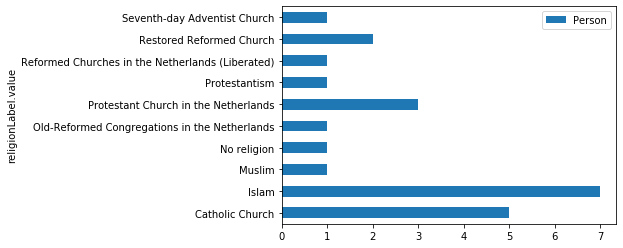

In [8]:
sparql = SPARQLWrapper('https://query.wikidata.org/sparql')

sparql.setQuery('''
SELECT DISTINCT ?personLabel ?religionLabel
WHERE {
    ?person wdt:P3602 wd:Q42733725.
    ?person wdt:P140 ?religion
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
''')

sparql.setReturnFormat(JSON)
results = sparql.query().convert()
results_df = json_normalize(results['results']['bindings'])

religie= list()

for x in range(len(results_df['personLabel.value'])):
    religie.append(results_df['religionLabel.value'][x])

results_df[['personLabel.value', 'religionLabel.value']].rename(columns={'personLabel.value':'Person'
                                                                        }).groupby(['religionLabel.value']).count().plot.barh()

### PANDAS - Moties Rutte II 🐼
Naast de verzamelende SPARQL data is er ook een andere dataset gedownload waarin [alle moties van kabinet Rutte II](https://watstemthetparlement.nl) zijn opgeslagen. 

In [9]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("https://raw.githubusercontent.com/dieanderegast/datasets/main/StemmingenRutte2.csv",
                  sep=";", encoding='latin1')
df.head(2)

,id,file,document,title,date,proposaltype,votetype,result,voteURL,proposalURL,source,50PLUS,AOV,Bontes,Bontes/Van Klaveren,Brinkman,CD,CDA,ChristenUnie,D66,De Jong,Eerdmans/Van Schijndel,GPV,GroenLinks,Hendriks,Houwers,Klein,Kortenoeven/Hernandez,Kuzu/ ztrk,Lazrak,LN,LPF,Nawijn,Nijpels,PvdA,PvdD,PVV,RPF,SGP,SP,Unie 55+,Van Klaveren,Van Oudenallen,Van Vliet,Verdonk,Verkerk,VVD,Wijnschenk,Wilders,reign,author,authorparty,supporter,supporterparties,category,subcategory,categories,pro,contra
0,20121114-h-tk-20122013-22-10-100267125,33410,47,Kabinetsformatie 2012 ; Motie; Motie van het l...,14/11/2012,Motion,Normal,adopted,https://zoek.officielebekendmakingen.nl/h-tk-2...,https://zoek.officielebekendmakingen.nl/kst-33...,OB,1.0,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,Kabinet-Rutte II,[Arie Slob],[ChristenUnie],"[Sybrand van Haersma Buma, Alexander Pechtold,...","[CDA, D66, SGP]",[Bestuur],[Organisatie en beleid],"Bestuur, Organisatie en beleid","[50PLUS, CDA, ChristenUnie, D66, GroenLinks, P...",[]
1,20121114-h-tk-20122013-22-10-117924796,33410,49,Kabinetsformatie 2012 ; Motie; Motie van het l...,14/11/2012,Motion,Normal,rejected,https://zoek.officielebekendmakingen.nl/h-tk-2...,https://zoek.officielebekendmakingen.nl/kst-33...,OB,1.0,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,Kabinet-Rutte II,[Arie Slob],[ChristenUnie],"[Sybrand van Haersma Buma, Alexander Pechtold,...","[CDA, D66, GroenLinks, 50PLUS, SGP, PVV, PvdD,...",[Bestuur],[Organisatie en beleid],"Bestuur, Organisatie en beleid","[50PLUS, CDA, ChristenUnie, D66, GroenLinks, P...","[PvdA, VVD]"


### Filteren 📌
Vervolgens is deze dataset is gefilterd op partijen en volksvertegenwoordigers die zich verkiesbaar hebben gesteld tijdens de Tweede Kamerverkieaingen van 2021, dus op de variabele `verkiesbaar` die voort komt uit de SPARQL query hiervoen. Daarnaast is ook andere, voor dit onderzoek minder relevante data, uit het dataframe verwijderd. Zo zijn we bijvoorbeeld niet geïntresseerd in de `voteURL` of `proposalURL`. Na het filteren ziet het dataframe er als volgt uit.

In [10]:
df1 = df[['title','date','proposaltype', 'result','author', 'authorparty', 'supporter', 'supporterparties', 'category', 'subcategory', 
           'categories', 'pro', 'contra']]
strip = ['author', 'authorparty', 'supporter', 'supporterparties', 'category', 'subcategory', 'categories', 'pro', 'contra']
split = ['supporter', 'supporterparties', 'category', 'subcategory', 'categories']
nospace = ['pro', 'contra']
for i in strip:
    if i in split:
        df1[i] = df1[i].str.strip('[]').str.split(",")
    elif i in nospace:
        df1[i] = df1[i].str.strip('[]').str.strip().str.split(",")
    else:
        df1[i] = df1[i].str.strip('[]')


for i, lijst in enumerate(df1['supporter']):
    l = []
    for j, persoon in enumerate(lijst):
        if persoon:
            if persoon[0] == ' ':
                df1['supporter'][i][j] = persoon[1:]
            if persoon in verkiesbaar:
                l.append(persoon)
    df1['supporter'][i] = l
    if df1['author'][i] not in verkiesbaar:
        df1['author'][i] = []

for index, row in df1.iterrows():
    if row['author'] == []:
        if row['supporter'] == []:
            df1.drop(index, inplace=True)

In [11]:
df1.head(2)

,title,date,proposaltype,result,author,authorparty,supporter,supporterparties,category,subcategory,categories,pro,contra
2,Kabinetsformatie 2012 ; Motie; Motie van de le...,14/11/2012,Motion,rejected,Bram van Ojik,GroenLinks,[Emile Roemer],[SP],[Bestuur],[Organisatie en beleid],"[Bestuur, Organisatie en beleid]","[50PLUS, GroenLinks, PvdD, SP]","[CDA, ChristenUnie, D66, PvdA, PVV, SGP, ..."
4,Kabinetsformatie 2012 ; Motie; Motie van de le...,14/11/2012,Motion,rejected,Emile Roemer,SP,[Marianne Thieme],[PvdD],[Bestuur],[Organisatie en beleid],"[Bestuur, Organisatie en beleid]","[ChristenUnie, GroenLinks, PvdD, SP]","[50PLUS, CDA, D66, PvdA, PVV, SGP, VVD]"


### Dataframe analyse 🎛️
Na het filteren van de moties is de dataset erg rijk. Zo bestaat het dataframe uit `5943` rijen en `24` kolommen. Dit komt neer op een totaal aantal datapunten van `77.233`. Genoeg materiaal op een aantal analyses op uit te voeren dus!
Eerst een paar analyses om achter de aard van de data te komen. Zo blijkt uit onderstaande code dat van alle moties meer dan `65%` wordt afgewezen.

In [12]:
print('Het dataframe telt',len(df1),'rijen,',len(df1.columns),'kolommen en dus', len(df1)*len(df1.columns),'datapunten')

## rejection rate
adopted = len(df1.loc[df1['result'] == 'adopted'] )
rejected = len(df1.loc[df1['result'] == 'rejected'])
average_rejection = rejected / len(df1['result'])

print(average_rejection,'% van de moties werd afgewezen')

Het dataframe telt 5941 rijen, 13 kolommen en dus 77233 datapunten
0.6586433260393874 % van de moties werd afgewezen


### Het afwijzen van moties ❌
Leuk en aardig dat er zoveel moties werden afgewezen. Maar wie wees al die moties eigenlijk af? Uit de code hieronder blijkt dat de `VVD` het vaakst tegen een motie stemt, gevolgd door de `PvdA` en `SGP`. Ook blijkt uit de data-analyse dat deze partijen het met meer dan  `50%` van de moties oneens is. De VVD stemt zelfs maar bij 1 op de 4 moties voor. Kun je hieruit afleiden dat partijen als de VVD conservatief zijn? Aangezien ze zoveel moties willen afwijzen? Nee, die uitspraak is te voorbarig. Dat heeft immers met de **context** van de motie te maken.

Wezen het vaakst een motie af 

  VVD          4504
 PvdA         3790
 SGP          2993
 Van Vliet    2767
 D66          2586
Name: contra, dtype: int64 

Wezen het vaakst een motie af(%) 

   VVD          75.812153
 PvdA         63.793974
 SGP          50.378724
 Van Vliet    46.574651
 D66          43.528026
Name: contra, dtype: float64 



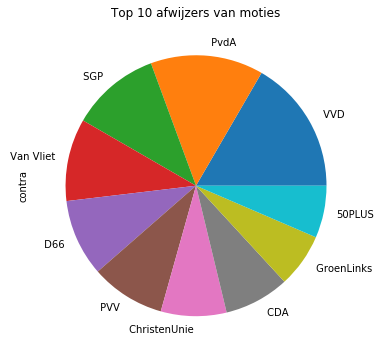

In [13]:
dfContra = df1[['contra']].explode('contra')
contra = dfContra['contra'].value_counts().head(5)
contra2 = dfContra['contra'].value_counts().head(10)

dfPie = contra2.plot.pie(figsize=(6, 6), title='Top 10 afwijzers van moties')

print('Wezen het vaakst een motie af \n\n', contra, '\n')
print('Wezen het vaakst een motie af(%) \n\n ', contra/len(df1) * 100, '\n')

### Het aannemen van moties ✅
Nu we weten wie het het vaakst moties afwezen, is het ook interessant om te weten welke partijen er het vaakst voor een bepaalde motie stemden. uit de data-analyse blijkt dat de `SP` het vaakst een motie aanneemt, gevolgd door de `PvdD` en `50PLUS`. Ook stemmen deze partijen (afgerond) in met `70%` van de moties of meer. Kun je hieruit afleiden dat partijen als de SP progressief zijn? Aangezien ze zoveel moties willen aannemen? Ook hier is die conclusie te kort door de bocht. De **context** van de motie is hier ook weer het belangrijkst.

Keurden het vaakst een motie goed 

  SP              4346
 PvdD            4288
50PLUS           4144
 GroenLinks      3764
 ChristenUnie    3214
Name: pro, dtype: int64 

Keurden het vaakst een motie goed(%) 

   SP              73.152668
 PvdD            72.176401
50PLUS           69.752567
 GroenLinks      63.356337
 ChristenUnie    54.098637
Name: pro, dtype: float64 



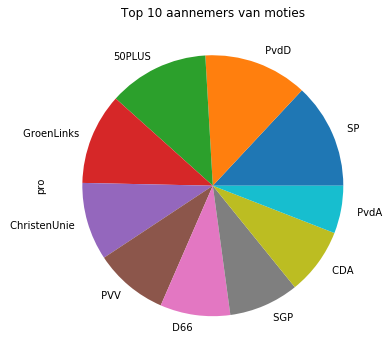

In [14]:
dfPro = df1[['pro']].explode('pro')
pro = dfPro['pro'].value_counts().head(5)
pro2 = dfPro['pro'].value_counts().head(10)

dfPie2 = pro2.plot.pie(figsize=(6, 6), title='Top 10 aannemers van moties')

print('Keurden het vaakst een motie goed \n\n', pro, '\n')
print('Keurden het vaakst een motie goed(%) \n\n ', pro/len(df1) * 100, '\n')

### Indienen van moties 📩
Nu we weten welke politieke partijen het vaakst moties afwijzen of aannemen, is hieronder aangegeven welke partijen het vaakst een motie hebben ingediend. Hieruit blijkt dat de `SP` en de `PVV` het vaakst een motie indienen.

Dienden het vaakst een motie in 

 SP      1041
PVV      986
CDA      982
D66      599
PvdD     495
Name: authorparty, dtype: int64 

Dienden het vaakst een motie in (%) 

 SP      17.522303
PVV     16.596533
CDA     16.529204
D66     10.082478
PvdD     8.331931
Name: authorparty, dtype: float64 



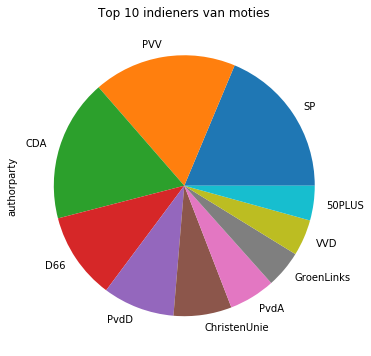

In [15]:
dfDien = df1[['authorparty']]
indieners = dfDien['authorparty'].value_counts().head(5)
indieners2 = dfDien['authorparty'].value_counts().head(10)

dfPie3 = indieners2.plot.pie(figsize=(6, 6), title='Top 10 indieners van moties')

print('Dienden het vaakst een motie in \n\n', indieners, '\n')
print('Dienden het vaakst een motie in (%) \n\n', indieners/len(df1) * 100, '\n')

### Het netwerk 🕸️
Dit is het netwerk van partijen die motie indienen en partijen die hen steunen in die moties. Iedere pijl gaat van een ondersteuner naar de indiener. Onder het netwerk is gevisualiseerd hoeveel moties iedere partij heeft ingediend die aanvaard of geweigerd zijn.

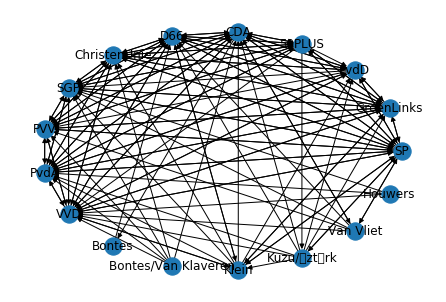

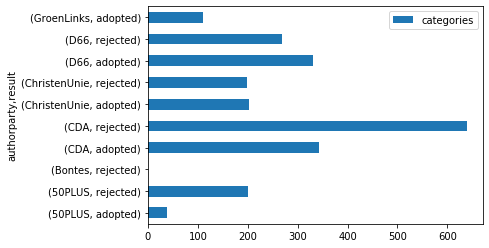

In [16]:
dfTeam = df1[['authorparty', 'supporterparties']].explode('supporterparties')
dfTeam['supporterparties'] = dfTeam['supporterparties'].str.strip()
dfTeam.head(10)
G = nx.from_pandas_edgelist(dfTeam, source='supporterparties', target='authorparty', edge_attr=True, create_using=nx.DiGraph())
G.remove_node('')
pos=nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()

dfResult = df1[['result', 'authorparty', 'supporterparties', 'categories']]
dfResult[['authorparty', 'result', 'categories']].groupby(['authorparty', 'result']).count().head(10).plot.barh()

### Motie categorie 📥
Dan hebben we hier de hoeveelheid moties die iedere partij heeft ingediend per categorie en dan per subcategorie. Het zou interessant zijn om in vervolg onderzoek te kijken naar hoe dit correleert met bijvoorbeeld leeftijd of hoeveelheid kinderen. Dienen partijen met meer kinderen meer moties in ten behoeve van het onderwijs? 

Natuurlijk moeten we dan wel een dataset gebruiken waarbij de intentie van de motie duidelijk is. De PVV dient bijvoorbeeld veel moties in over de begroting, maar wordt de begroting daar dikker of dunner van?

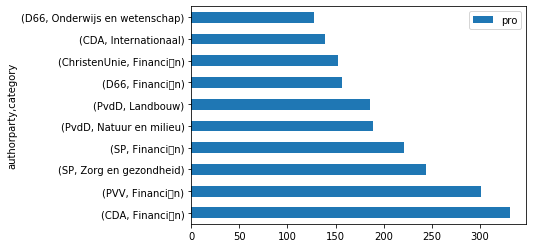

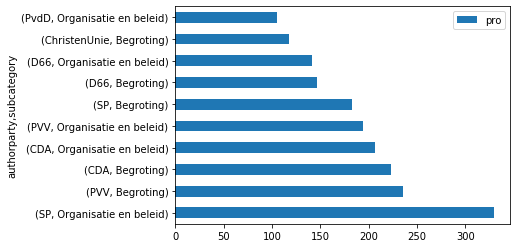

In [17]:
dfCata = df1[['authorparty', 'category', 'pro']].explode('category')
dfCata['category'] = dfCata['category'].str.strip()
dfCata = dfCata[['authorparty', 'category', 'pro']].groupby(['authorparty', 'category']).count().sort_values(['pro'], ascending=False).head(10)
dfCata.plot.barh()

dfCata2 = df1[['authorparty', 'subcategory', 'pro']].explode('subcategory')
dfCata2['subcategory'] = dfCata2['subcategory'].str.strip()
dfCata2 = dfCata2[['authorparty', 'subcategory', 'pro']].groupby(['authorparty', 'subcategory']).count().sort_values(['pro'], ascending=False).head(10)
dfCata2.plot.barh()

## Conclusie 🤔
Voorafgaand aan het end-to-end linked data project 'een objectief beeld van het politieke klimaat🗞️' was de doelstelling om de data helder en inzichtelijk te maken, om zo objectieve informatie over het politieke klimaat te geven. Deze doelstelling is in zekere zin gehaald. Er is een objectieve weergave gegeven van bepaalde onderdelen binnen de politiek. Zo is weergegeven hoeveel volksvertegenwoordigers en partijen er met de verkiezingen meedoen, hoe de context van deze groep mensen eruit ziet (zoals bijvoorbeeld geloofsovertuiging en aantal kinderen) of wat bijvoorbeeld het stemgedrag van partijen bij moties is.

Vervolgens is deze informatie met elkaar gecombineerd door bepaalde Wikidata (SPARQL) te combineren met moties uit kabinet rutte II. Hieruit is voortgekomen dat...

Er kan geconcludeerd worden dat dit soort analyses een eerste, oriënterende stap zijn naar het objectief inzichtelijk maken van politieke data en informatie. Het is daarnaast voor ons ook een eerste stap om vanuit een informatiekundige, objectieve manier  naar de politiek te te kijken. Iets wat tot op de dag van vandaag nog te weinig gebeurd. Natuurlijk Politiek blijft in zekere zin altijd subjectief, aangezien het over standpunten en overtuigingen gaat, maar wij zijn ervan overtuigd dat feitelijke informatie een prominentere plek binnen het politieke klimaat kan hebben. Met deze opdracht is een eerste stap in die richting gezet. 

Er kan echter ook geconcludeerd worden dat er nog zoveel meer mogelijk is. Zo kunnen er niet alleen complexere analyses uitgevoerd worden, maar is het ook een kunst en uitdaging om deze informatie op een juiste manier bij de kiezer te krijgen. Hierbij is het van groot belang om dit op een objectieve manier te doen zonder de data te manipuleren, zodat het gedrag de kiezer niet beïnvloed wordt data-analisten. Ook dit kan gezien worden als een informatiekundige uitdaging met een politicologisch randje.